In [136]:
import numpy as np
import pandas as pd
import random
import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns 
import yaml
from pathlib import Path

from util.functions import logistic
from structure_generation.path_connection_gen import ProceduralGraphGenerator, StatsUtils, GraphStructureGenerator




In [137]:

conf = yaml.safe_load(Path('config.yml').read_text())['reachability']


In [138]:
geometric_graph_conf = conf['random_geometric']


In [139]:
results_dict_list = []
modality = "causal"
for graph_rad in geometric_graph_conf['graph_edge_radii']:
    results_dict = {
        "timesteps_saturation" : [],
        "fraction_infected_list" : [],
        "info_dict" : []
    }
    print(f"simulation run for graph radius {graph_rad}")
    mean_degree_simulation_runs = []
    for i, repeat in tqdm.tqdm(enumerate(range(conf['num_simulation_runs']))):
        graphgen = GraphStructureGenerator(
            structure_name=conf['structure_name'], 
            num_nodes=int(geometric_graph_conf['nodes']), 
            graph_edge_radius = float(graph_rad)
        )
        graph = graphgen.initial_adj_matrix
        graph_rand = graphgen.get_graph_structure().initial_adj_matrix

        x = ProceduralGraphGenerator(graph)
        infection_matrix_list, timesteps_saturation, fraction_infected_list, info_dict = x.infect_till_saturation(
            modality=modality, verbose= False
        )

        results_dict["timesteps_saturation"].append(timesteps_saturation)
        results_dict["fraction_infected_list"].append(fraction_infected_list)
        results_dict["info_dict"].append(info_dict)
    
    results_dict_list.append(results_dict)

simulation run for graph radius 0.025


5it [00:00, 42.31it/s]


simulation run for graph radius 0.05


5it [00:19,  3.88s/it]


In [140]:
len(results_dict_list)

2

In [141]:
import itertools
for result in tqdm.tqdm(results_dict_list): 
    for key in result.keys():
        if key == "fraction_infected_list":
            # Pad the list to ones to the longest saturation length, find the mean across all simulations and the std at each timestep
            padded_list = np.array(
                list(zip(*itertools.zip_longest(*result[key], fillvalue=1)))
            )
            result[key] = np.mean(padded_list, axis=0)
        if key == "info_dict":
            info_dict_temp = {k : None for k in result['info_dict'][0].keys()}
            for key in info_dict_temp.keys():
                info_dict_temp[key] = np.average([x[key] for x in result['info_dict']])
            result['info_dict'] = info_dict_temp
        
    result['average_timesteps'] = np.average(result['timesteps_saturation'])

100%|██████████| 2/2 [00:00<00:00, 529.78it/s]


In [142]:
import matplotlib
test = results_dict_list[0]
test

{'timesteps_saturation': [15, 3, 15, 5, 14],
 'fraction_infected_list': array([0.30782051, 0.46320513, 0.68397436, 0.73397436, 0.76730769,
        0.76730769, 0.76730769, 0.76730769, 0.76730769, 0.76730769,
        0.76730769, 0.81346154, 0.82884615, 0.875     , 1.        ]),
 'info_dict': {'average_degree': 2.538974358974359,
  'num_nodes': 8.0,
  'clustering_coefficient': 0.4994017094017093,
  'degree_assortivity': -0.03600606639686376,
  'mean_shortest_pathlength': 2.2418315018315016},
 'average_timesteps': 10.4}

KeyError: 'modality'

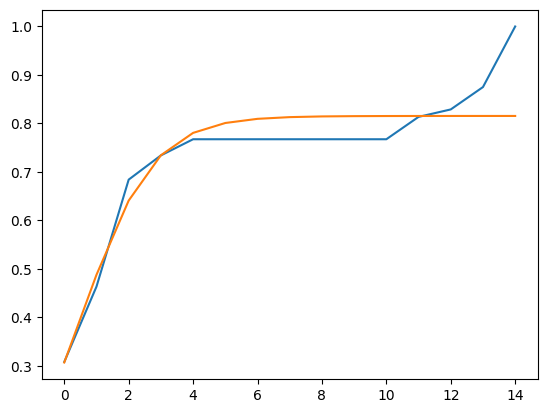

In [143]:
timesteps_list = [x for x in range(len(test['fraction_infected_list']))]

p, cov = curve_fit(logistic, timesteps_list, test['fraction_infected_list'])
logistic_curve_data = logistic(timesteps_list, *p)

plt.plot(timesteps_list, test['fraction_infected_list'], label = f"average simulated saturation across {len(test['timesteps_saturation'])} runs")
plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
plt.title(f"saturation curve for modality {test['modality']}")
plt.legend()

In [ ]:
            p, cov = curve_fit(logistic, timesteps, fraction_infected_list)


In [ ]:
try: 
            #Fit a logistic curve to the simulated infection data for one simulation run, generate data with this logistic, use to find residuals in fit
            p, cov = curve_fit(logistic, timesteps, fraction_infected_list)
            logistic_curve_data = logistic(timesteps, *p)
            residuals_dict[graph_rad].extend(fraction_infected_list - logistic_curve_data)
            mean_degree_simulation_runs.append(average_degree)
        except RuntimeError as e:
            print(e)
            pass 
    average_degrees.append(np.mean(mean_degree_simulation_runs))

#Update keys of dictionary so that keys are the (averaged) mean degree of the simulations networks
residuals_dict = {k : v for k,v in list(zip(average_degrees, residuals_dict.values()))}
least_noisy_data = residuals_dict
for key in residuals_dict.keys(): 
    sns.kdeplot(residuals_dict[key], label=f"mean degree : {round(key, 2)}")
plt.legend()
plt.show()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 7)